In [7]:
%reload_ext autoreload
%autoreload 2
from fun import *
import polars as pl
import pandas as pd
import datetime as dt
import time 
import logging

logging = get_logger(log_file='回测.log')

start_date = dt.date(2021,1,1)
end_date = dt.datetime.today()

# 获取指定日期的日线数据
stock_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_stock_all_data')
stock_data = stock_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down'])
market_value = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_daily_basic')
market_value = market_value.with_columns([
   ( pl.col('free_share')*pl.col('close')/1e4).alias('free_float_mv')
])
stock_data = stock_data.join(market_value.select(['code','trading_date','free_float_mv']),on=['code','trading_date'],how='left')
#stock_data.schema

In [ ]:
# 1.涨停标记
# 标记涨停状态：limit_status
stock_data = mark_limit_status(stock_data)
# 标记涨停描述：limit_desc
stock_data = mark_limit_desc(stock_data)
# 记录最近的一次涨停描述：last_limit_desc
stock_data = mark_last_limit_desc(stock_data)

# 2.均线特征
# 计算均线:sma_{window}
stock_data = add_sma(stock_data, window=5)
stock_data = add_sma(stock_data, window=7)
"""
#stock_data = add_ema(stock_data, window=4)
#stock_data = add_ema(stock_data, window=7)
#stock_data = add_ewma_volatility(stock_data, window=8)
"""
# 3.计算开盘涨幅:open_chg,乖离率,成交均价vwap
stock_data = stock_data.with_columns(
    (
        (pl.col("open") - pl.col("pre_close")) 
        / pl.col("pre_close") 
        * 100
    ).alias("open_pct"),  # 开盘涨幅百分比
    ((pl.col("close") - pl.col("sma_7")) / pl.col("sma_7") * 100).alias("close_sma7_pct"), #乖离率
    (pl.col("amount")*100 / pl.col("volume")).alias("vwap"),
    ((pl.col("low") <= pl.col("limit_down")*1.01)).alias("touch_limit_down"), # 是否触及跌停
)
stock_data = cal_n_lowest(stock_data)


# 3.k线特征
# 计算量比,k线特征
#stock_data = add_volume_ratio(stock_data, window=5)
#stock_data = cal_kline_pattern_features(stock_data)


# 筛选stock_data行 为买入信号 1. 昨日涨停or断板or炸板   2.今日低开-3%至-4%  3.昨日收盘在昨日日五线上   4. 最近一次涨停描述 !=一天一板 或者 非空
# 1. 先确保数据按股票和日期排序
stock_data = stock_data.sort(["code", "trading_date"])

# 2. 在每个股票组内计算移位数据（关键步骤）
stock_data = stock_data.with_columns([
    # 同一股票内的前一天涨停状态
    pl.col("limit_status").shift(1).over("code").alias("prev_limit_status"),
    # 同一股票内的前一天5日均线
    pl.col("sma_7").shift(1).over("code").alias("prev_sma_7"),
    #pl.col("ema_7").shift(1).over("code").alias("prev_ema_7"),
    #pl.col("volume_ratio_5").shift(1).over("code").alias("pre_volume_ratio_5"),
    pl.col("pct").shift(1).over("code").alias("pre_pct"),
    pl.col("vwap").shift(1).over("code").alias("pre_vwap"),
    #pl.col("ewma_volatility_8").shift(1).over("code").alias("pre_ewma_volatility_8"),
    pl.col("close_sma7_pct").shift(1).over("code").alias("pre_close_sma7_pct"),
    
    # k线特征
    # pl.col("body_ratio").shift(1).over("code").alias("pre_body_ratio"),
    # pl.col("upper_shadow_ratio").shift(1).over("code").alias("pre_upper_shadow_ratio"),
    # pl.col("lower_shadow_ratio").shift(1).over("code").alias("pre_lower_shadow_ratio"),
    # pl.col("candle_direction").shift(1).over("code").alias("pre_candle_direction")
])

# 3. 基于组内移位后的数据筛选买入信号
# 条件参数字典
params_dict={
    'low':-5,
    'high':-2.5,
    'mv_min':35,
    'mv_max':1000,
    'prev_limit_status':['断板','炸板']
}
# polars的信号文件
信号文件= stock_data.filter(
    # 非st,创业,科创
    ~(pl.col("type").is_not_null() & (pl.col("type") == "ST")) &
    ~(pl.col("code").str.split(".").list[1].str.starts_with("30") | pl.col("code").str.split(".").list[1].str.starts_with("688")) &

    # 1. 昨日or断板or炸板（使用组内移位后的数据）
    (pl.col("prev_limit_status").is_in(params_dict['prev_limit_status'])) &
    
    # 2. 今日低开-3%至-4%
    (pl.col("open_pct") >= params_dict["low"]) & (pl.col("open_pct") <= params_dict["high"]) &
    
    # 3. 昨日收盘在昨日5日均线上
    (pl.col("pre_close") >= pl.col("prev_sma_7")) &
    
    # 4. 最近一次涨停描述 != 一天一板 或者 空缺
    (
        (pl.col("last_limit_desc") != "1天1板") &
        #(pl.col("last_limit_desc") == "2天1板") 
        (pl.col("last_limit_desc").is_not_null())
    ) &

    # 5. 自由流通值大于
    ((pl.col("free_float_mv") >= params_dict["mv_min"]) & (pl.col("free_float_mv") <= params_dict["mv_max"])) 

    # 6. 绝对位置不能太高，不能触发严重异动
    & ((pl.col("open")/pl.col("lowest_30")) <=3 )
    
    # 均线偏离度大于11或小于9
    #& ((pl.col("pre_close_sma7_pct") <= 9))
)
# 筛选数据并添加signal列
stock_data = stock_data.with_columns(
    # 构建筛选条件表达式
    signal = pl.when(
        # 非st,创业,科创
        ~(pl.col("type").is_not_null() & (pl.col("type") == "ST")) &
        ~(pl.col("code").str.split(".").list[1].str.starts_with("30") | 
          pl.col("code").str.split(".").list[1].str.starts_with("688")) &

        # 1. 昨日or断板or炸板（使用组内移位后的数据）
        (pl.col("prev_limit_status").is_in(params_dict['prev_limit_status'])) &

        # 2. 今日低开-3%至-4%
        (pl.col("open_pct") >= params_dict["low"]) & 
        (pl.col("open_pct") <= params_dict["high"]) &

        # 3. 昨日收盘在昨日5日均线上（注意你代码里写的是prev_sma_7，确认是否是笔误）
        (pl.col("pre_close") >= pl.col("prev_sma_7")) &

        # 4. 最近一次涨停描述 != 一天一板 且 非空
        (pl.col("last_limit_desc") != "1天1板") &
        (pl.col("last_limit_desc").is_not_null()) &

        # 5. 自由流通值区间
        (pl.col("free_float_mv") >= params_dict["mv_min"]) & 
        (pl.col("free_float_mv") <= params_dict["mv_max"]) &
        # 6. 绝对位置不能太高，不能触发严重异动
        ((pl.col("open")/pl.col("lowest_30")) <= 3)
        
    ).then(1).otherwise(0)
)

# 如果需要只筛选出signal=1的行（可选）
信号文件 = stock_data.filter(pl.col("signal") == 1)

logging.info(f"回测信号参数: {params_dict}")

回测信号参数: {'low': -5, 'high': -2.5, 'mv_min': 35, 'mv_max': 1000, 'prev_limit_status': ['断板', '炸板']}


In [9]:
from trade_fun import *
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")
#end_date_str = '2025-11-17'

logging.info(f"回测时间区间: {start_date_str} 至 {end_date_str}")
result_df,merged_df = cal_trade_info(信号文件,trade_fun=trade,start_date=start_date_str,end_date=end_date_str)


回测时间区间: 2021-01-01 至 2025-12-30
使用40个进程并行处理，共825个日期任务
回测任务进度: 100%|███████████████████████| 825/825 [02:47<00:00,  4.93个日期/s]
所有回测任务完成，共处理825个日期的结果


1.33.1


e:\working\anaconda3\envs\quant\lib\functools.py:888: DataOrientationWarning:

Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.



总调整天数: 98, 调整正确率: 56.68%, 预计平均亏损改善: 2.3788%



回测时间:2025-01-02 - 2025-12-30
策略胜率: 53.55%
策略盈亏比: 1.71
每日平均开仓个数: 2.53
平均持仓天数: 1.63 天
每单位风险期望收益:0.4493
策略总收益率: 170.97%
策略年化收益率: 173.22%
最大回撤: -6.27%
最大回撤阶段: 2025-04-24 至 2025-04-25
夏普比率: 4.11
策略超额年化收益率: 154.85%
最终净值: 2.7097


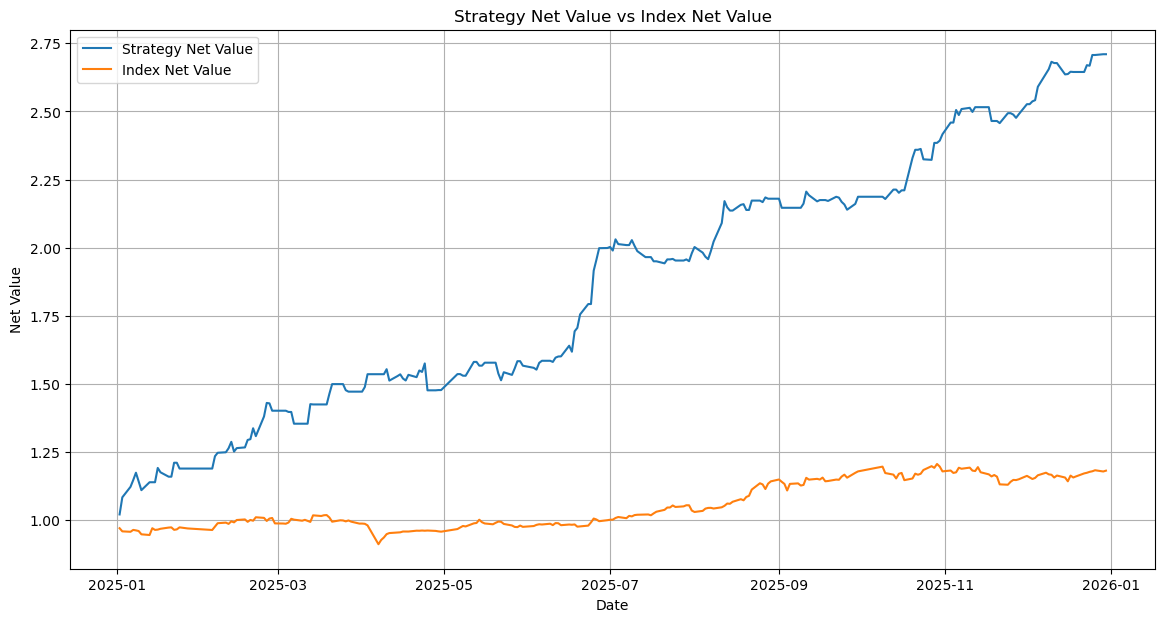

In [ ]:
def report_backtest_full(
    result_df: pd.DataFrame,
    start_date,
    end_date,
    profit_col: str = 'profit',
    buy_date_col:str = 'buy_time',
    sell_date_col: str = 'buy_time',
    holding_days_col:str = 'holding_days',
    benchmark_code: str = "399300.SZ",
    risk_free_rate: float = 0.02,
    return_method = 'compound',
    plot = True,
    second_y = True
):
    """
    result_df 交割单:包括策略的 1.卖出信息 2.利润信息 的交割单
    回测结果汇报函数（含净值曲线、最大回撤、夏普比率、超额收益等）
    """
    # 忽略
    from fun import get_logger
    logging = get_logger(log_file='回测.log')

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import tinyshare as tns
    from mapping import convert_code_format,clean_stocks_data
    ts_token = 'YzAEH11Yc7jZCHjeJa63fnbpSt3k9Je3GvWn0390oiBKO95bVJjP7u5L34e2ff6b'
    ts =tns.pro_api(ts_token)

    # 1. 策略净值曲线计算
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    result_df[sell_date_col] = pd.to_datetime(result_df[sell_date_col])
    result_df = result_df[
        (result_df[sell_date_col] >= start_date) & 
        (result_df[sell_date_col] <= end_date)
    ]
    result_df = result_df.sort_values(sell_date_col).reset_index(drop=True)
    result_df['sell_date_date'] = pd.to_datetime(result_df[sell_date_col]).dt.date
    result_df['buy_date_date'] = pd.to_datetime(result_df[buy_date_col]).dt.date # 提取买入日期（仅日期部分）
    daily_returns = result_df.groupby('sell_date_date')[profit_col].mean() / 100  # 转为小数
    net_values = (1 + daily_returns).cumprod()
    if return_method!='compound':
        net_values = 1 + daily_returns.cumsum()  # 单利：初始净值1 + 每日收益累计和
    strategy_curve = net_values.copy()
    #strategy_curve.index = pd.to_datetime(strategy_curve.index).normalize()

    # 2. 获取指数净值曲线
    index_data = ts.index_daily(ts_code=convert_code_format(benchmark_code,format='suffix'), start_date=start_date.strftime('%Y%m%d'), end_date=end_date.strftime('%Y%m%d'))
    index_data = clean_stocks_data(index_data)
    index_df = index_data
    index_df['trading_date_date'] = pd.to_datetime(index_df['trading_date']).dt.date
    index_df = index_df.sort_values('trading_date_date').reset_index(drop=True)
    if not index_df.empty:
        if 'pct' not in index_df.columns:
            index_df['pct'] = index_df['close'].pct_change()
        index_df['net_value'] = (1 + index_df['pct']/100).cumprod()
        index_curve = index_df.set_index('trading_date_date')['net_value']
    else:
        raise ValueError("未获取到有效的指数数据")

    # 3. 对齐日期
    strategy_curve = strategy_curve.sort_index()
    index_curve = index_curve.sort_index()
    strategy_curve = strategy_curve.reindex(index_curve.index, method='ffill').fillna(1)

    # 4. 核心指标
    total_return = strategy_curve.iloc[-1] - 1 if len(strategy_curve) > 0 else 0
    if len(strategy_curve) >= 2:
        first_date = strategy_curve.index[0]
        last_date = strategy_curve.index[-1]
        total_days = (last_date - first_date).days
        years = total_days / 365
    else:
        years = 0
    annualized_return = (strategy_curve.iloc[-1]) ** (1 / years) - 1 if years > 0 and strategy_curve.iloc[-1] > 0 else 0

    # 最大回撤
    roll_max = strategy_curve.cummax()
    drawdown = (strategy_curve - roll_max) / roll_max
    max_drawdown = drawdown.min()
    # 找到最大回撤的开始和结束时间
    max_drawdown_end = drawdown.idxmin()
    # 找到最大回撤开始时间（即之前的最高点）
    max_drawdown_start = roll_max.loc[:max_drawdown_end].idxmax()

    # 夏普比率
    daily_ret = strategy_curve.pct_change().dropna()
    daily_drawdown = daily_ret.where(daily_ret < 0, 0)
    rf_daily = risk_free_rate / 252
    excess_daily = daily_ret - rf_daily
    sharpe_ratio = (excess_daily.mean() / excess_daily.std()) * np.sqrt(252) if excess_daily.std() > 0 else 0

    # 超额收益
    bench_years = (index_curve.index[-1] - index_curve.index[0]).days / 365 if len(index_curve) > 1 else 0
    bench_annual = (index_curve.iloc[-1]) ** (1 / bench_years) - 1 if bench_years > 0 else 0
    excess_return = annualized_return - bench_annual

    # 胜率和盈亏比
    # 筛选出结果不等于0的记录（排除盈亏平衡的情况）
    non_zero_df = result_df[result_df[profit_col] != 0]

    # 计算赢率：大于0的笔数 / 不等于0的笔数
    win_rate = (non_zero_df[profit_col] > 0).mean()
    avg_win = result_df[result_df[profit_col] > 0][profit_col].mean()
    avg_loss = abs(result_df[result_df[profit_col] < 0][profit_col].mean())
    profit_loss_ratio = avg_win / avg_loss if avg_loss != 0 else float('inf')

    # 平均开仓个数
    daily_buy_count = result_df.groupby('buy_date_date')['code'].nunique()
    # 计算平均值（排除无买入的日期，仅统计有交易的日期）
    avg_daily_buy_count = daily_buy_count.mean() if not daily_buy_count.empty else 0

    # 平均持仓天数
    valid_holding_days = result_df[
        result_df[holding_days_col].notna() &  # 排除空值
        (result_df[holding_days_col] > 0)      # 排除0或负数（异常数据）
    ][holding_days_col]
    avg_holding_days = valid_holding_days.mean() if not valid_holding_days.empty else 0

    # 8. 将结果整理成DataFrame并返回
    metrics_df = pd.DataFrame({
        '指标名称': [
            '回测开始日期', '回测结束日期', '策略胜率', '策略盈亏比',
            '每单位风险期望收益', '策略总收益率', '策略年化收益率',
            '最大回撤', '最大回撤开始日期', '最大回撤结束日期',
            '夏普比率', '策略超额年化收益率',
            '最终净值','每日平均买入股票个数', '平均持仓天数',
        ],
        '指标值': [
            first_date, last_date, f"{win_rate:.2%}",
            f"{profit_loss_ratio:.2f}", f"{win_rate*(profit_loss_ratio+1) - 1 :.4f}",
            f"{total_return:.2%}", f"{annualized_return:.2%}", f"{max_drawdown:.2%}",
            max_drawdown_start, max_drawdown_end,
            f"{sharpe_ratio:.2f}", f"{excess_return:.2%}", f"{strategy_curve.iloc[-1]:.4f}",
            f"{avg_daily_buy_count:.2f}", f"{avg_holding_days:.2f} 天"
        ]
    })

    if not plot:
        return metrics_df
    # 5. 输出结果
    logging.info(
        f"\n回测时间:{strategy_curve.index[0]} - {strategy_curve.index[-1]}\n"
        f"策略胜率: {win_rate:.2%}\n"
        f"策略盈亏比: {profit_loss_ratio:.2f}\n"
        f"每日平均开仓个数: {avg_daily_buy_count:.2f}\n"
        f"平均持仓天数: {avg_holding_days:.2f} 天\n"
        f"每单位风险期望收益:{win_rate*(profit_loss_ratio+1) -1 :.4f}\n"
        f"策略总收益率: {total_return:.2%}\n"
        f"策略年化收益率: {annualized_return:.2%}\n"
        f"最大回撤: {max_drawdown:.2%}\n"
        f"最大回撤阶段: {max_drawdown_start} 至 {max_drawdown_end}\n"
        f"夏普比率: {sharpe_ratio:.2f}\n"
        f"策略超额年化收益率: {excess_return:.2%}\n"
        f"最终净值: {strategy_curve.iloc[-1]:.4f}"
    )

    
    # 6. 绘制净值曲线
    plt.figure(figsize=(14, 7))
    plt.plot(strategy_curve.index, strategy_curve.values, label='Strategy Net Value')
    plt.plot(index_curve.index, index_curve.values, label='Index Net Value')
    plt.xlabel('Date')
    plt.ylabel('Net Value')
    plt.title('Strategy Net Value vs Index Net Value')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 7. 使用plotly绘制可交互净值曲线（新增回撤直方图）
    # 创建图形 - 修改为3个子图：净值曲线、收益直方图、回撤直方图
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        subplot_titles=('净值曲线对比', '策略每日收益率', '策略每日回撤'),
        specs=[
            [{"secondary_y": True}],  # 净值曲线（双Y轴）
            [{"secondary_y": False}], # 收益直方图
            [{"secondary_y": False}]  # 回撤直方图
        ],
        row_heights=[0.5, 0.25, 0.13]  # 调整子图高度比例
    )

    # 7.1 添加策略净值曲线（左Y轴）
    fig.add_trace(
        go.Scatter(
            x=strategy_curve.index, 
            y=strategy_curve.values, 
            name='策略净值',
            line=dict(color='#1f77b4', width=2),
            hovertemplate='日期: %{x}<br>策略净值: %{y:.4f}<extra></extra>'
        ),
        row=1, col=1,
        secondary_y=False
    )

    # 7.2 添加指数净值曲线（右Y轴）
    fig.add_trace(
        go.Scatter(
            x=index_curve.index, 
            y=index_curve.values, 
            name='指数净值',
            line=dict(color='#ff7f0e', width=2),
            hovertemplate='日期: %{x}<br>指数净值: %{y:.4f}<extra></extra>'
        ),
        row=1, col=1,
        secondary_y=second_y
    )

    # 7.3 添加每日收益率直方图
    # 准备收益率数据和颜色
    ret_colors = ['#d62728' if x > 0 else '#2ca02c' for x in daily_ret.values]
    
    fig.add_trace(
        go.Bar(
            x=daily_ret.index, 
            y=daily_ret.values, 
            name='策略每日收益率',
            marker_color=ret_colors,
            hovertemplate='日期: %{x}<br>收益率: %{y:.2%}<extra></extra>'
        ),
        row=2, col=1
    )

    # 7.4 添加每日回撤直方图
    fig.add_trace(
        go.Bar(
            x=daily_drawdown.index, 
            y=daily_drawdown.values, 
            name='策略每日回撤',
            marker_color='#2ca02c',  # 绿色
            hovertemplate='日期: %{x}<br>回撤率: %{y:.2%}<extra></extra>'
        ),
        row=3, col=1
    )

    # 7.5 更新布局
    fig.update_layout(
        height=800,  # 增加高度以容纳3个子图
        title_text="回测结果可视化",
        title_font=dict(size=16, weight='bold'),
        hovermode="x unified",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font=dict(size=12)
        ),
        plot_bgcolor='rgba(248,248,248,1)',  # 浅灰色背景
        paper_bgcolor='white'
    )

    # 7.6 更新轴标签和样式
    # 净值曲线轴标签
    fig.update_yaxes(title_text="策略净值", secondary_y=False, row=1, col=1, 
                     title_font=dict(size=12), tickfont=dict(size=10))
    fig.update_yaxes(title_text="指数净值", secondary_y=True, row=1, col=1,
                     title_font=dict(size=12), tickfont=dict(size=10))
    
    # 收益率轴标签
    fig.update_yaxes(title_text="收益率", row=2, col=1,
                     title_font=dict(size=12), tickfont=dict(size=10),
                     tickformat='.2%')  # 百分比格式
    
    # 回撤轴标签
    fig.update_yaxes(title_text="回撤率", row=3, col=1,
                     title_font=dict(size=12), tickfont=dict(size=10),
                     tickformat='.2%')  # 百分比格式
    
    # X轴样式
    fig.update_xaxes(
        title_text="日期", row=3, col=1,
        tickfont=dict(size=10, family='Arial', color='gray'),
        #tickangle=-45,
        title_font=dict(size=12)
    )

    # 7.7 添加网格线
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=1)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=2)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=3)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=1)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=2)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.2)', row=3)

    # 显示图形
    fig.show()
    
    return metrics_df

from fun import *
from trade_fun import adjust_weight_by_near_n # 触及跌停调仓

# 取sell_date为前n个窗口的股票表现与平均水平进行对比。高于平均水平并且昨日的股票触及跌停达到一定比率，则仓位调整为min_weight
def adjust_weight_by_near_n(回测结果, max_weight=0.4, min_weight=0, window=20, down_limit_ratio=0.35,win_rate_threshold=0.43, profit_loss_ratio_threshold=1.4):
    import polars as pl
    if isinstance(回测结果, pd.DataFrame):
        回测结果 = pl.from_pandas(回测结果)
    
    # 按trading_date排序
    回测结果 = 回测结果.sort('trading_date')
    # 获取唯一的交易日期列表
    trading_dates = 回测结果['trading_date'].unique().to_list()
    # 利用sell_time获取出sell_date.（sell_time为datetime）
    回测结果 = 回测结果.with_columns(
        pl.col('sell_time').dt.date().alias('sell_date')
    )
    
    # 生成「日期-权重」映射表（每个日期对应一个权重）
    date_weight = []
    for i, current_date in enumerate(trading_dates):
        # 前window天数据不足时，默认最大仓位
        if i < window:
            date_weight.append((current_date, max_weight))
            continue
        
        # 取当前日期之前的window天作为统计窗口
        window_dates = trading_dates[i - window : i]
        window_data = 回测结果.filter(pl.col('sell_date').is_in(window_dates))
        
        # ---------------------- 1. 计算前window天的胜率和盈亏比 ----------------------
        # 处理窗口内无数据的情况
        total_in_window = window_data.height
        if total_in_window == 0:
            win_rate = 0.0
            profit_loss_ratio = 0.0
        else:
            # 拆分盈利/亏损交易
            win_trades = window_data.filter(pl.col('profit') > 0)
            loss_trades = window_data.filter(pl.col('profit') < 0)
            
            # 计算胜率（盈利交易数/总交易数）
            win_count = win_trades.height
            win_rate = win_count / total_in_window
            
            # 计算盈亏比（平均盈利 / 平均亏损的绝对值）
            avg_win = win_trades['profit'].mean() if win_count > 0 else 0.0
            avg_loss_abs = abs(loss_trades['profit'].mean()) if loss_trades.height > 0 else 0.0
            
            # 处理极端情况：无亏损交易时盈亏比设为极大值（视为达标）；无盈利交易时设为0
            if avg_loss_abs == 0:
                profit_loss_ratio = float('inf')
            elif avg_win == 0:
                profit_loss_ratio = 0.0
            else:
                profit_loss_ratio = avg_win / avg_loss_abs
        
        # 2. 计算昨日的跌停比率
        previous_date = trading_dates[i - 1]
        previous_data = 回测结果.filter(pl.col('trading_date') == previous_date)
        
        # 处理昨日无数据的情况
        total_previous = previous_data.height
        if total_previous == 0:
            down_ratio = 0  # 无数据时视为跌停比率为0
        else:
            down_count = previous_data.filter(pl.col('touch_limit_down') == True).height
            down_ratio = down_count / total_previous
        
        # ---------------------- 3. 双条件判断：调整仓位 ----------------------
        # 条件1：前window天胜率≥阈值 且 盈亏比≥阈值（视为"高于平均水平"）
        # 条件2：昨日跌停比率≥阈值
        if (win_rate >= win_rate_threshold) and (profit_loss_ratio >= profit_loss_ratio_threshold) and (down_ratio >= down_limit_ratio):
            date_weight.append((current_date, min_weight))
        # elif (win_rate<=0.4 and profit_loss_ratio<=1.4 and down_ratio>=down_limit_ratio):
        #     date_weight.append((current_date, 0))
        else:
            date_weight.append((current_date, max_weight))
    
    # 合并权重数据并清理临时列
    weight_df = pl.DataFrame(date_weight, schema=['trading_date', 'weight'])
    回测结果 = 回测结果.join(weight_df, on='trading_date', how='left')
    
    # 汇报调整正确率以及调整绩效(调整后减亏比例=(max_weight-min_weight)*(-profit).mean() )
    total_adjusted = weight_df.filter(pl.col('weight') == min_weight).height # 调整天数
    merged_with_weight = 回测结果.join(weight_df, on='trading_date', how='left')
    if total_adjusted == 0:
        adjust_success_rate = 0.0
        total_profit_loss_improvement = 0.0
    else:
        adjusted_trades = merged_with_weight.filter(pl.col('weight') == min_weight)
        losing_trades = adjusted_trades.filter(pl.col('profit') < 0)
        total_losing_trades = losing_trades.height
        if total_losing_trades == 0:
            adjust_success_rate = 1.0  # 全部调整成功
            total_profit_loss_improvement = 0.0
        else:
            # 亏损交易调成min_weight即为正确调整
            adjust_success_rate = total_losing_trades / adjusted_trades.height*100
            # 计算总的改善比例
            total_profit_loss_improvement = (max_weight - min_weight) * (-losing_trades['profit']).mean() 
    print(f"总调整天数: {total_adjusted}, 调整正确率: {adjust_success_rate:.2f}%, 预计平均亏损改善: {total_profit_loss_improvement:.4f}%")
    return 回测结果.drop('sell_date')


print(pl.__version__)
#print(type(merged_df))
# 构建文件名
filename = f"信号文件/断板低开{params_dict['low']}-{params_dict['high']} {dt.datetime.now().strftime('%Y%m%d_%H%M%S')}(sma7).csv"
# 使用Python的文件操作指定编码
#merged_df.write_csv(filename, include_bom=True)

result_df1 = pd.read_csv('信号文件/断板低开-5--2.5 20251024_100549(sma7).csv',encoding='utf-8-sig') 
result_df2 = pd.read_csv('信号文件/涨停低开-5--2.5 20251016_061011(ma7).csv',encoding='utf-8-sig')
result_df3 = pd.read_csv('信号文件/断板低开-5--2.5 20251121_214049(sma7).csv',encoding='utf-8-sig') # 10日线

# 仓位控制风控(merged_df_with_weight)
merged_df_with_weight = adjust_weight_by_near_n(merged_df) 
"""触及跌停风控"""
merged_df_with_weight = merged_df_with_weight.with_columns(
    (pl.col("profit") * pl.col("weight")).alias("weight_profit")
)
#merged_df_with_weight.write_csv(filename, include_bom=True)
# 买点下移风控(merged_df_with_weight_adjust)
rate_move = 0.02
# 增加买点下移的逻辑（当weight=0时,如果low<=open*(1-rate_move)时,买点下移rate_move（也就是profit+rate_move*100），否则profit=0）
merged_df_with_weight_adjust = merged_df_with_weight.with_columns(
    pl.when(pl.col("weight") != 0)
    # 条件1：weight≠0 → 保持原profit不变
    .then(pl.col("profit"))
    # 条件2：weight==0 → 进一步判断low是否满足下移条件
    .otherwise(
        pl.when(pl.col("low") <= pl.col("open") * (1 - rate_move))
        # 子条件1：满足下移 → profit+rate_move*100
        .then(pl.col("profit") + rate_move * 100)
        # 子条件2：不满足下移 → profit=0
        .otherwise(0)
    ).alias("profit")  # 覆盖原profit列
) #买点下移回测
"""买点下移风控"""
merged_df_with_weight_adjust = merged_df_with_weight_adjust.with_columns(
    (pl.col("profit") *0.4).alias("weight_profit")
)

merged_df = merged_df.with_columns((pl.col("profit") *0.4).alias("weight_profit"))
result_df['weight_profit'] = result_df['profit'] *0.4
result_df1['weight_profit'] = result_df1['profit'] *0.4
result_df2['weight_profit'] = result_df2['profit'] *0.4
result_df3['weight_profit'] = result_df3['profit'] *0.4

# 回测结果汇报
back_result =report_backtest_full(merged_df_with_weight.to_pandas(), start_date = '2025-01-01', end_date=end_date_str,profit_col='weight_profit',return_method='simple')
# 将回测结果保存到日志中
#logging.info("\n" + back_result.to_string(index=False))


回测时间:2025-01-02 - 2025-12-30
策略胜率: 51.25%
策略盈亏比: 1.68
每日平均开仓个数: 2.53
平均持仓天数: 1.63 天
每单位风险期望收益:0.3743
策略总收益率: 377.39%
策略年化收益率: 383.62%
最大回撤: -10.56%
最大回撤阶段: 2025-02-25 至 2025-03-07
夏普比率: 3.88
策略超额年化收益率: 365.25%
最终净值: 4.7739


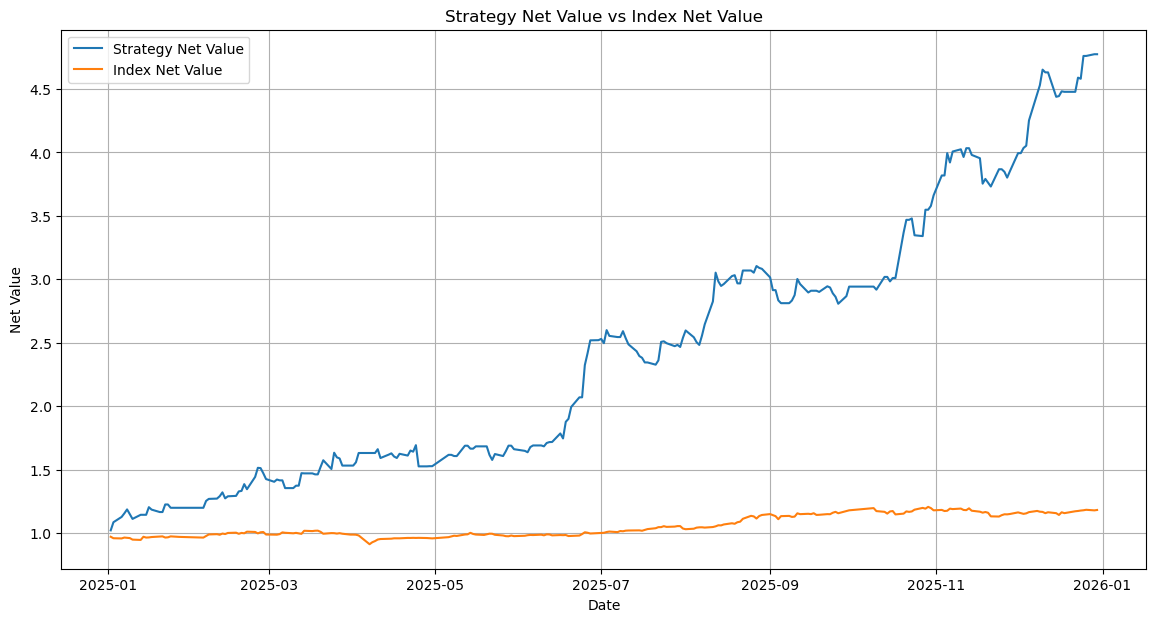

In [11]:
#back_result =report_backtest_full(result_df, start_date = '2025-01-01', end_date='2025-12-20',profit_col='weight_profit')
back_result =report_backtest_full(merged_df_with_weight_adjust.to_pandas(), start_date = '2025-01-01', end_date=end_date_str,profit_col='weight_profit')


C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 56.25%
策略盈亏比: 2.48
每日平均开仓个数: 1.18
平均持仓天数: 1.60 天
每单位风险期望收益:0.9576
策略总收益率: 11.80%
策略年化收益率: 2.27%
最大回撤: -3.63%
最大回撤阶段: 2022-11-28 至 2024-10-09
夏普比率: 0.11
策略超额年化收益率: 4.60%
最终净值: 1.1180


正在计算分组 nan 的回测指标


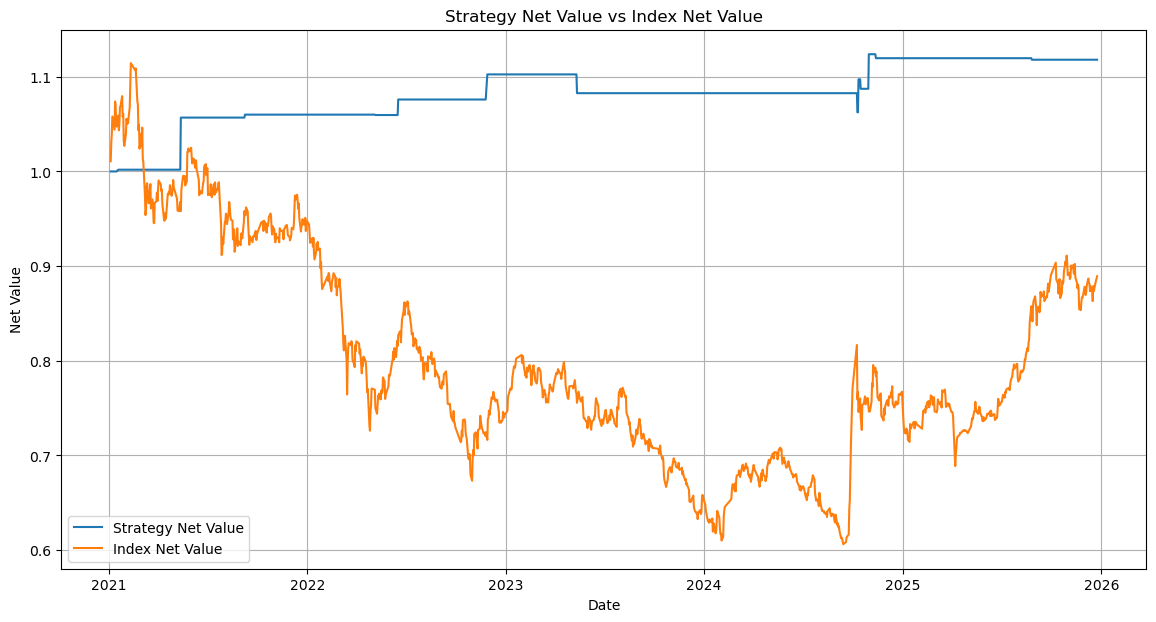

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 42.45%
策略盈亏比: 1.38
每日平均开仓个数: 1.06
平均持仓天数: 1.57 天
每单位风险期望收益:0.0094
策略总收益率: 18.01%
策略年化收益率: 3.39%
最大回撤: -30.15%
最大回撤阶段: 2021-08-18 至 2022-12-02
夏普比率: 0.17
策略超额年化收益率: 5.72%
最终净值: 1.1801


正在计算分组 (25, 50] 的回测指标


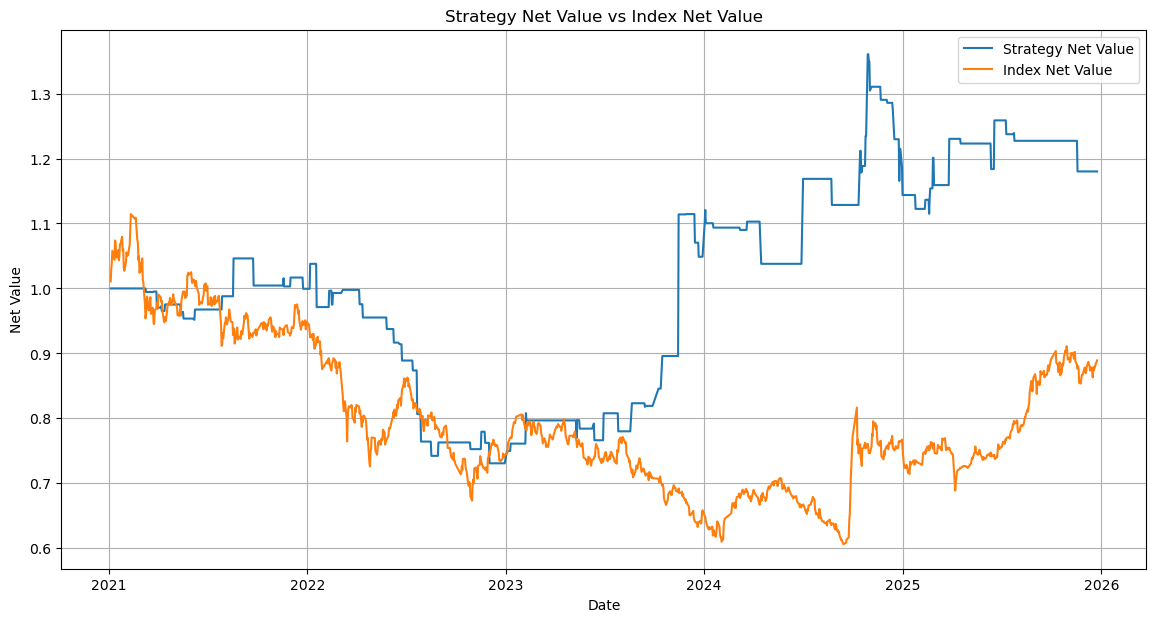

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 47.98%
策略盈亏比: 1.62
每日平均开仓个数: 1.45
平均持仓天数: 1.60 天
每单位风险期望收益:0.2563
策略总收益率: 242.20%
策略年化收益率: 28.07%
最大回撤: -18.39%
最大回撤阶段: 2022-08-17 至 2024-11-13
夏普比率: 1.29
策略超额年化收益率: 30.40%
最终净值: 3.4220


正在计算分组 (50, 90] 的回测指标


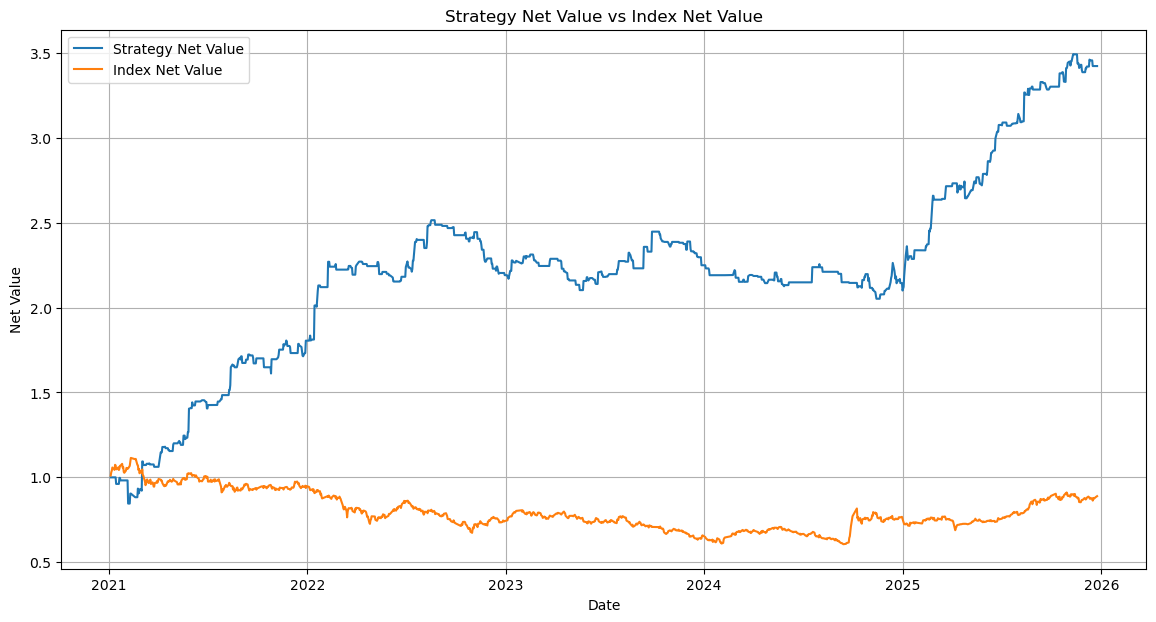

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 47.71%
策略盈亏比: 1.46
每日平均开仓个数: 1.22
平均持仓天数: 1.61 天
每单位风险期望收益:0.1759
策略总收益率: 107.14%
策略年化收益率: 15.77%
最大回撤: -9.55%
最大回撤阶段: 2022-12-09 至 2023-06-27
夏普比率: 0.94
策略超额年化收益率: 18.10%
最终净值: 2.0714


正在计算分组 (90, 120] 的回测指标


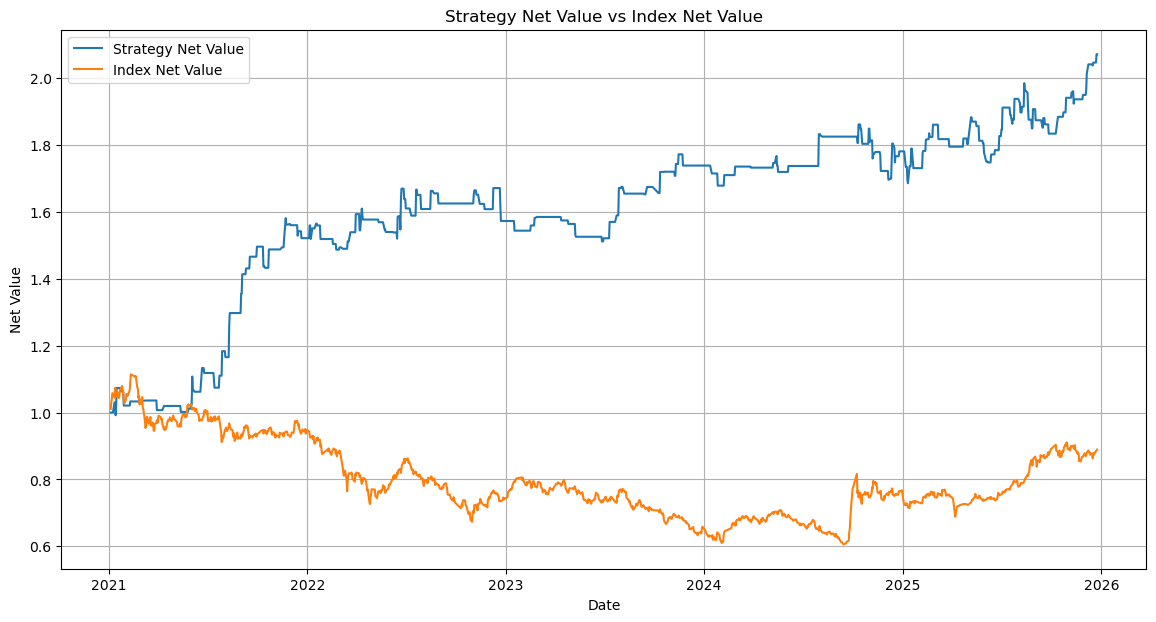

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 51.30%
策略盈亏比: 1.41
每日平均开仓个数: 1.20
平均持仓天数: 1.58 天
每单位风险期望收益:0.2379
策略总收益率: 113.57%
策略年化收益率: 16.49%
最大回撤: -15.48%
最大回撤阶段: 2022-12-06 至 2024-11-06
夏普比率: 0.99
策略超额年化收益率: 18.82%
最终净值: 2.1357


正在计算分组 (120, 160] 的回测指标


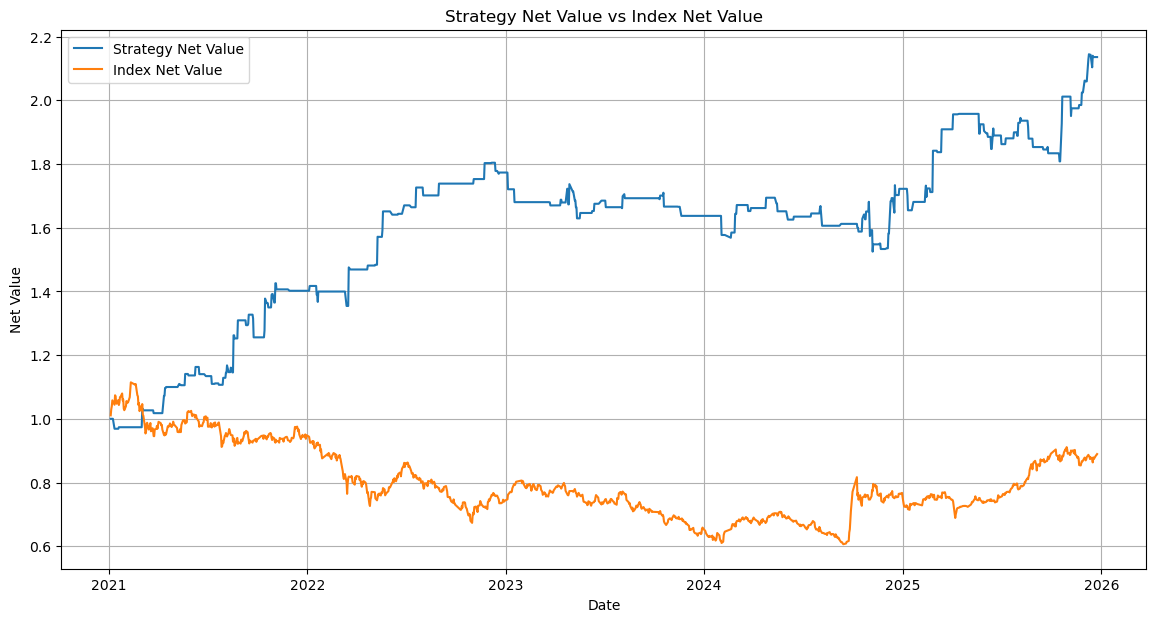

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 46.57%
策略盈亏比: 1.48
每日平均开仓个数: 1.31
平均持仓天数: 1.60 天
每单位风险期望收益:0.1558
策略总收益率: 39.52%
策略年化收益率: 6.93%
最大回撤: -36.26%
最大回撤阶段: 2021-02-23 至 2024-10-11
夏普比率: 0.34
策略超额年化收益率: 9.26%
最终净值: 1.3952


正在计算分组 (160, 250] 的回测指标


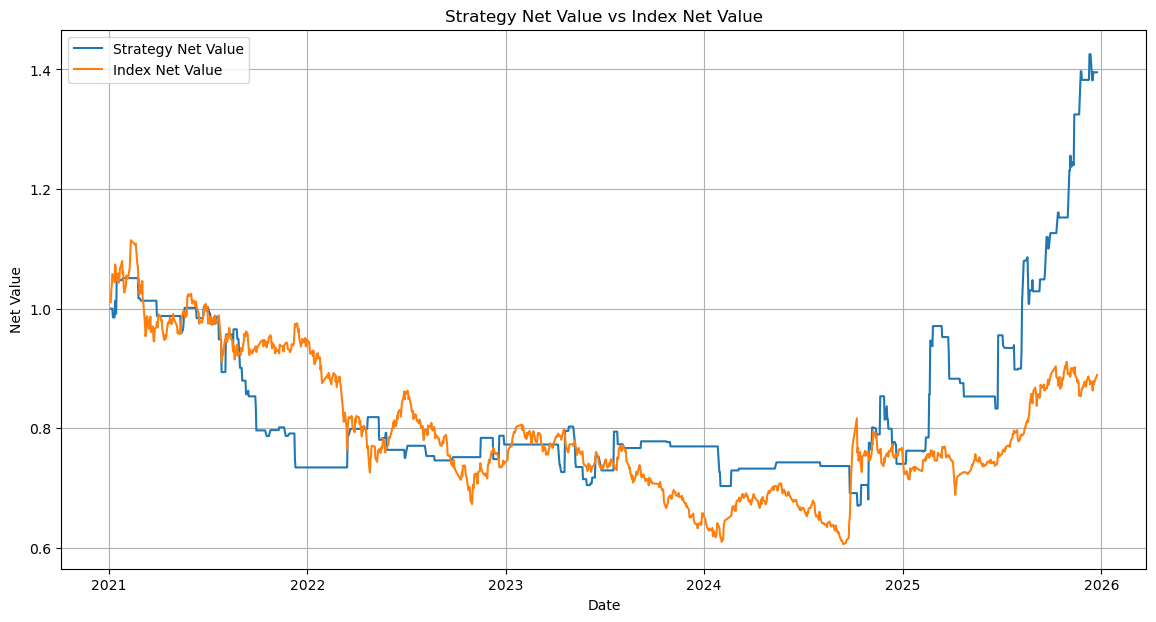

C:\Users\20561\AppData\Local\Temp\ipykernel_28652\3517205183.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


回测时间:2021-01-04 - 2025-12-24
策略胜率: 49.21%
策略盈亏比: 1.76
每日平均开仓个数: 1.51
平均持仓天数: 1.58 天
每单位风险期望收益:0.3568
策略总收益率: 119.54%
策略年化收益率: 17.13%
最大回撤: -13.89%
最大回撤阶段: 2021-03-10 至 2021-09-30
夏普比率: 1.06
策略超额年化收益率: 19.47%
最终净值: 2.1954


正在计算分组 (250, 1000] 的回测指标


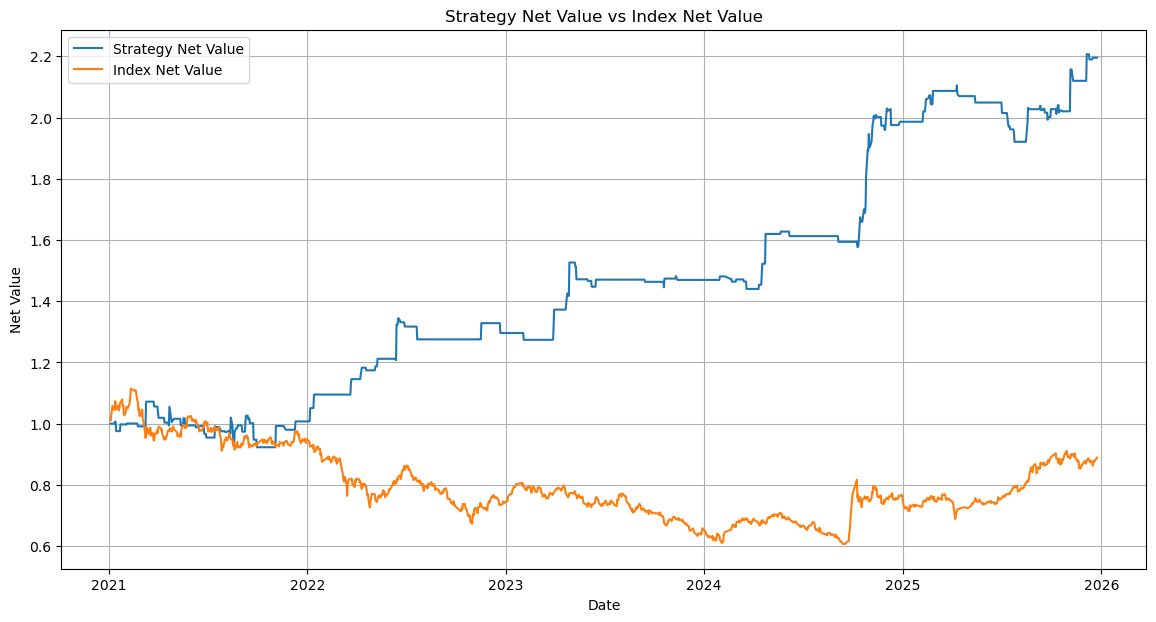

分组描述性统计：
   _factor_bin    样本数        均值        标准差        最小值      25分位       中位数  \
0          nan   20.0  2.638298   7.511842  -6.919921 -1.800651  0.339431   
1     (25, 50]  115.0  0.205220  10.598695 -20.557315 -5.864023 -1.693919   
2     (50, 90]  723.0  1.073876   9.434111 -34.084415 -4.647708 -0.517845   
3    (90, 120]  308.0  1.202679   8.915598 -16.085855 -5.289530  0.235544   
4   (120, 160]  259.0  0.834792   8.780858 -16.892787 -4.897010 -0.150200   
5   (160, 250]  235.0  0.429399   8.709937 -13.738594 -5.181313 -1.173970   
6  (250, 1000]  280.0  1.359536   9.026106 -14.473227 -4.198740 -0.251450   

       75分位        最大值      回测开始日期  ...   策略总收益率 策略年化收益率     最大回撤    最大回撤开始日期  \
0  6.566514  22.948953  2021-01-04  ...   11.80%   2.27%   -3.63%  2022-11-28   
1  4.251190  54.497052  2021-01-04  ...   18.01%   3.39%  -30.15%  2021-08-18   
2  5.487502  50.088349  2021-01-04  ...  242.20%  28.07%  -18.39%  2022-08-17   
3  6.155840  30.103543  2021-01-04  ...  107.14%  

In [12]:
import pandas as pd
import numpy as np
import plotly.express as px


def factor_group_profit_plot(
    df: pd.DataFrame,
    factor_col: str,
    profit_col: str,
    bins: int = 5,
    bin_method: str = 'qcut',
    plot: bool = True,
    report_func=report_backtest_full,  # 新增参数，回测汇报函数
    report_kwargs={
        'start_date': '2025-01-01',
        'end_date': end_date,
        'profit_col': 'profit'
    } # 新增参数，回测函数的额外参数
) -> pd.DataFrame:
    """
    按因子分组统计收益率，并可对每组调用回测汇报函数，结果合并到desc_stats
    """
    import pandas as pd
    import numpy as np
    import plotly.express as px

    df = df.copy()
    factor_dtype = df[factor_col].dtype
    start_date = report_kwargs.get('start_date', '2025-01-01')
    end_date = report_kwargs.get('end_date')
    df = df[
        (pd.to_datetime(df['trading_date']) >= pd.to_datetime(start_date)) &
        (pd.to_datetime(df['trading_date']) <= pd.to_datetime(end_date))
    ]

    if np.issubdtype(factor_dtype, np.number):
        if bin_method == 'qcut':
            df['_factor_bin'] = pd.qcut(df[factor_col], q=bins, duplicates='drop')
        else:
            df['_factor_bin'] = pd.cut(df[factor_col], bins=bins)
        group_col = '_factor_bin'
        df['_factor_bin'] = df['_factor_bin'].astype(str)
        def get_bin_midpoint(bin_value):
            if isinstance(bin_value, pd.Interval):
                return (bin_value.left + bin_value.right) / 2
            else:
                try:
                    bin_str = str(bin_value).strip('[]() ')
                    left_str, right_str = bin_str.split(',')
                    left = float(left_str.strip())
                    right = float(right_str.strip())
                    return (left + right) / 2
                except Exception:
                    return 0
        unique_bins = df[group_col].dropna().unique()
        bin_order = sorted(unique_bins, key=get_bin_midpoint)
        df[group_col] = pd.Categorical(df[group_col], categories=bin_order, ordered=True)
    else:
        group_col = factor_col
        df[group_col] = pd.Categorical(df[group_col], categories=sorted(df[group_col].unique()), ordered=True)

    desc_stats = df.groupby(group_col, observed=True)[profit_col].describe().reset_index()
    desc_stats = desc_stats.rename(columns={
        'count': '样本数', 'mean': '均值', 'std': '标准差', 'min': '最小值',
        '25%': '25分位', '50%': '中位数', '75%': '75分位', 'max': '最大值'
    })[[group_col, '样本数', '均值', '标准差', '最小值', '25分位', '中位数', '75分位', '最大值']]

    # 新增：对每个分组调用回测汇报函数
    if report_func is not None:
        metrics_dict_list = []
        for group in desc_stats[group_col]:
            group_df = df[df[group_col] == group]
            if len(group_df) == 0:
                metrics_dict_list.append({})
                continue
            try:
                if report_kwargs.get('plot')==True:
                    print(f"正在计算分组 {group} 的回测指标")
                metrics = report_func(group_df, **(report_kwargs or {}))
                # 转为字典：{指标名称: 指标值}
                metrics_dict = dict(zip(metrics['指标名称'], metrics['指标值']))
            except Exception as e:
                metrics_dict = {}
            metrics_dict_list.append(metrics_dict)
        # 将所有指标合并到desc_stats
        metrics_df = pd.DataFrame(metrics_dict_list)
        desc_stats = pd.concat([desc_stats, metrics_df], axis=1)

    if plot:
        fig = px.violin(
            df, y=profit_col, x=group_col, box=True, points="all",
            title=f"{factor_col}分组收益率分布",
            labels={group_col: "分组", profit_col: "收益率"}
        )
        fig.show()
        print("分组描述性统计：")
        print(desc_stats)

    return desc_stats


#merged_df1 = pd.read_csv('断板低开-5--2.5 20251011_100035.csv',encoding='utf-8-sig') 
df = cal_industry_concentration(merged_df_with_weight.to_pandas(), window=3)
# 因子值计算
#df['trading_date'] = pd.to_datetime(df['trading_date'])
df['price/lowest_30'] = df['open']/df['lowest_30']
#df['pre_candle_direction*pre_body_ratio'] = df['pre_candle_direction']*df['pre_body_ratio']
#df['open-volume_concentration_10/volume_concentration_10'] = (df['open'] - df['pre_volume_concentration_10'])/df['pre_volume_concentration_10'] *100
#df = df[(df['trading_date'] >= '2025-04-08')]
# 分组分析
#desc= factor_group_profit_plot(df, 'pre_volume_ratio_5', 'profit', bins=[0,0.7,0.9,1,1.2,1.4,1.5,1.7,2,2.5,3,4,5], bin_method='cut')
desc= factor_group_profit_plot(df, 'float_mv', 'profit', bins=[25,50,90,120,160,250,1000], bin_method='cut',
    report_func=report_backtest_full,  # 你的回测函数
    report_kwargs={
        'start_date': '2021-01-01',
        'end_date': '2025-12-24',
        'profit_col': 'weight_profit',
        'return_method':'compand',
        'plot':True  # 避免在每次调用时绘图
    })
#desc= factor_group_profit_plot(df, 'pre_candle_direction', 'profit', bins=3, bin_method='cut')
#desc = factor_group_profit_plot(df, 'price/lowest_30', 'profit', bins=[0,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.5,3], bin_method='cut')
#desc = factor_group_profit_plot(df, 'pre_candle_direction*pre_body_ratio', 'profit', bins=[-1,-0.5,0,0.5,1], bin_method='cut')

#desc = factor_group_profit_plot(df, 'pre_body_ratio', 'profit', bins=5, bin_method='qcut')
#desc = factor_group_profit_plot(df, 'pre_ewma_volatility_8', 'profit', bins=10, bin_method='qcut') #pre_close_sma7_pct
# desc = factor_group_profit_plot(
#     df,
#     factor_col='industry_concentration',
#     profit_col='profit',
#     bins=4,
#     bin_method='qcut',
#     report_func=report_backtest_full,  # 你的回测函数
#     report_kwargs={
#         'start_date': '2021-01-01',
#         'end_date': '2025-12-24',
#         'profit_col': 'weight_profit',
#         'plot': True  # 避免在每次调用时绘图
#     }
# )
# result_cat = factor_group_profit_plot(df, 'prev_limit_status', 'profit', plot=True)